# Sentimentic analysis on Amazon Fine Food Reviews Dataset:
    由於MovieLens 資料集沒有用戶評論，因此改為使用Amazon Food Reviews 資料集，這個資料及包含用戶ID、產品ID、用戶評論、好評率等等。
    我會利用機器學習的方法試著分析資料，並給出分數預測以及好評率預測，最後再觀察結果後，給出結論與學習心得。
## 本分析之目錄：
#### 資料預處理（包含用nltk處理文字）
#### 分數預測
    logistic regression model on word count
    logistic regression model on TFIDF
    logistic regression model on TFIDF+ngram
#### 好評率預測
    logistic regression model on word count
    logistic regression model on TFIDF+ngram
    Study on non-context features 
#### 對於個別用戶之行為預測
#### 觀察與分析結果

## 資料預處理
    First, let's load some libraries needed throughout the analysis.
    Second, use pd.read_csv for reading the data.
    Third, use numpy.where() to help us add some columns for upvote metrics (Helpful%, % upvote)
    Last, analysis the new data and determine the objective of the Sentimentic analysis on the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud

odf = pd.read_csv('/Users/roger/Desktop/Workspace/amazon-fine-food-reviews/Reviews.tsv')
odf['Helpful %'] = np.where(odf['HelpfulnessDenominator'] > 0, odf['HelpfulnessNumerator'] / odf['HelpfulnessDenominator'], -1)
odf['% Upvote'] = pd.cut(odf['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
odf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


    觀察完資料集後，我發現我並不能很直觀的看出評論與評分的關係，因此我接著要做的是利用圖表幫助我判斷以上關係。

Text(0.5,1,'How helpful users find among user scores')

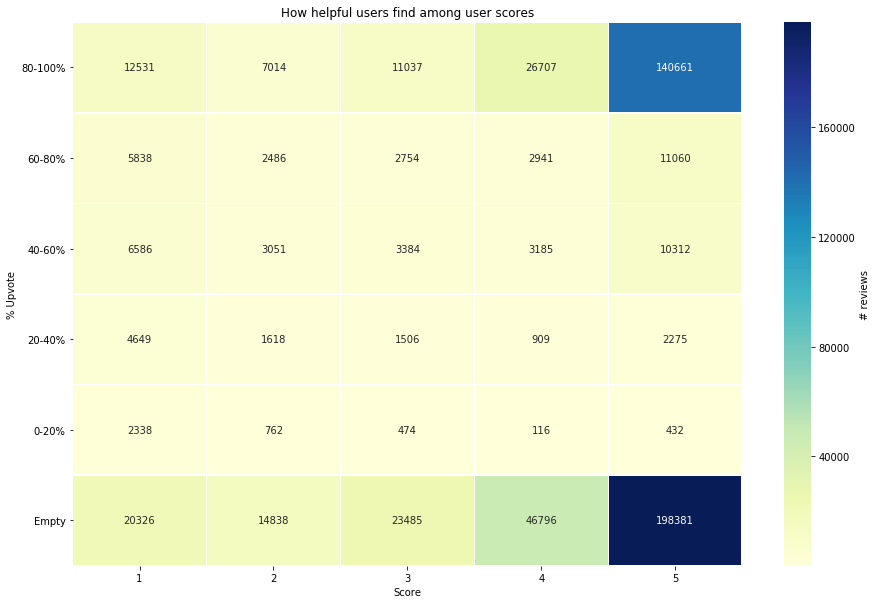

In [4]:
df_s = odf.groupby(['Score', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')

#### 由以上圖表，我們可以發現：
    1. 用戶評論會偏向高分數的食物。
    2. 沒有被評論的食物有超過一半的比例。
    3. 大多數人認同評分為5分的食物，也就是對於好吃的食物每個人的喜好不會有很大的差異。

### 顧客評論內容處理
    接著，我要開始分析顧客的評論，因此我先將它分為好評與差評。
    由於評分為3屬於顧客不喜歡也不討厭的食物，因此我先將其汰除掉，也就是評分大於3歸之為好評，反之，則為差評。

In [5]:
df = odf[odf['Score'] != 3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

## Score Prediction
    處理完以上資料後，我們就可以開始設計模型和訓練資料，以得出我們想要看到的結果。
    在這邊，我們的目的是利用顧客評論進行分數預測。
    因此，首先我們要做的是定義幾個我們接下來會經常使用的工具，以加快我們的效率。
    接著，我們就可以利用自己熟悉的方式去顯現模型跑出來的結果，在這邊要注意的是，我們不需要將所有的資料都顯示出來，我們只想看到比較極端的值，因此我們只需要取前20positive與negative的資料就可以了。

In [7]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))

### LogicticRegession model on CountVectorizer
    第一個模型我們先利用CountVectorizer對文字進行向量化處理，並使用邏輯回歸（LogisticRegression）的方式對資料進行分類。
    使用這兩個後我們可以得出前20positive和negative的字詞，以及模型準確率的估計。

In [6]:
text_fit(X, y, c, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model Accuracy: 0.9387162049081809

-Top 20 positive-
Coefficient           Word
   3.329098     pleasantly
   3.205069  emeraldforest
   3.031077        chedder
   2.564327        easiest
   2.456505        solving
   2.450984        blowout
   2.374133       heartier
   2.370813      addicting
   2.301797     unwrapping
   2.300840          herrs
   2.294465         skewed
   2.292517       drawback
   2.290527         hooked
   2.263369         hahaha
   2.249899       downside
   2.241492     correction
   2.197172          whisk
   2.191359         ration
   2.190545         bertie
   2.170247     dishwasher

-Top 20 negative-
Coefficient           Word
  -2.466164     unfinished
  -2.492352       tastless
  -2.601571        weakest
  -2.613739      overrated
  -2.692912      cancelled
  -2.730855    unappealing
  -2.744304        furious
  -2.753579     oversalted
  -2.821892      deceptive
  -2.822589  disappointing
  -2.826292    undrinkable
  -2.829160    embarrassed
  -2.8743

    若由準確率來判斷，接近94%的準確率，可以看出結果是不錯的。
    但接著往下看，我們可以看到在前20positive與negative的資料中，有許多字詞是沒有意義的，例如：280mg、3095826......
    這樣也會導致我們無法利用評論內容準確的預測分數

### DummyClassifier model on CountVectorizer
    接著，我們可以利用DummyClassifier得出基礎準確率，這邊是使用positive類別為主要類別。

In [8]:
text_fit(X, y, c, DummyClassifier(),0)

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.7363944801983964


### LogisticRegession model on TFIDF Vectorizer
    接下來，因為剛才得出結果的不合理處，我利用修改文字向量化的方式（由CountVectorizer 改為 TF-IDF Vectorizer）進行嘗試，得出以下結果：

In [8]:
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Accuracy: 0.9346767690598993

-Top 20 positive-
Coefficient        Word
  13.722122       great
  12.147902   delicious
  12.014958        best
  10.605239     perfect
   9.860653   excellent
   9.581171       loves
   9.036909      highly
   8.363466        love
   7.966271   wonderful
   7.796376     amazing
   7.631784     awesome
   7.339035        good
   7.247790  pleasantly
   7.190196        nice
   7.020301      hooked
   6.956696       yummy
   6.941086    favorite
   6.929284     pleased
   6.883906      smooth
   6.728033   fantastic

-Top 20 negative-
Coefficient            Word
  -5.624256           waste
  -5.719871            poor
  -5.724237     undrinkable
  -6.012937            yuck
  -6.151728           stale
  -6.277542           worse
  -6.319804           bland
  -6.552196      disgusting
  -6.558868            weak
  -6.686740          return
  -6.731253           threw
  -6.837394       tasteless
  -7.436267   unfortunately
  -7.790216        horrible
  -

    由以上結果，我們可以發現以TF-IDF Vectorizer 進行的話，雖然準確率差不多，但字詞會變得合理許多，而且相對於CountVectorizer，係數的量值也會有相當大的提升，這對我們的分數預測的合理性與正確性都會更接近目標。

    雖然以上結果，我已經相當滿意，但我們還是不能放棄嘗試追求更好的模型，在這邊我嘗試了幾個不同的向量化方式，找到最能接近目標的方式：
### LogisticRegression model on TFIDF Vectorizer +ngram

In [9]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 3933179
# train records: 394360
# test records: 131454


/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Accuracy: 0.9454714196601093

-Top 20 positive-
Coefficient              Word
  21.054577             great
  17.831601              best
  17.012872         delicious
  14.624623           perfect
  13.611160             loves
  13.272387              love
  13.144334         excellent
  11.418326              good
  11.321080         wonderful
  10.811514              nice
  10.594919          favorite
   9.691426           amazing
   9.371318           awesome
   9.143947              easy
   8.947594           pleased
   8.906614             happy
   8.715677            smooth
   8.592553             yummy
   8.466686            highly
   8.423070  highly recommend

-Top 20 negative-
Coefficient            Word
  -7.807009           maybe
  -8.129029          hoping
  -8.250228       tasteless
  -8.319548           money
  -8.353005           worse
  -8.564717         thought
  -8.764723      disgusting
  -9.145294           bland
  -9.304977           threw
  -9.893504      

## Upvote prdiction 
    完成分數預測後，接著我們要進行的是好評率預測。
    在這邊，我們需要使用的是'%Upvote'欄位中的數據，與上面原因相同，我們將40-60%的好評率刪除，並以0-40%為negative（0），60-100%為positive（1），得出以下結果：

In [13]:
df = df[df['Score'] == 5]
df = df[df['% Upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df.shape

X = df['Text']
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = df['% Upvote'].map(y_dict)

print('Class distribution:')
print(y.value_counts())

Class distribution:
1    151721
0      2707
Name: % Upvote, dtype: int64


    從以上結果我們可以看出好評評論的數量是遠遠大於差評評論的數量。（也符合我們在最一開始觀察資料所得出的結論）
    因此，我們需要重構資料，讓兩者數量平衡，而採取的方式是隨機選取好評資料，選到與差評資料相同的量，使兩者所佔所有交易量的比率相同。

In [14]:
df_s = pd.DataFrame(data = [X,y]).T

Downvote_records = len(df_s[df_s['% Upvote'] == 0])
Downvote_indices = np.array(df_s[df_s['% Upvote'] == 0].index)

Upvote_indices = df_s[df_s['% Upvote'] == 1].index

random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices,random_upvote_indices])

under_sample_data = df_s.ix[under_sample_indices, :]
X_u = under_sample_data['Text']
under_sample_data['% Upvote'] = under_sample_data['% Upvote'].astype(int)
y_u = under_sample_data['% Upvote']


print("Percentage of upvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 1])/len(under_sample_data))
print("Percentage of downvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 0])/len(under_sample_data))
print("Total number of records in resampled data: ", len(under_sample_data))

Percentage of upvote transactions:  0.5
Percentage of downvote transactions:  0.5
Total number of records in resampled data:  5414


/Users/roger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


    OK，看到以上結果後，我們知道我們準備好了，可以接下去進行好評率預測了。
### Logistic Refression model on CountVectorizer
    這邊可以沿用以上分數預測使用的模型（text_fit()），但注意要將被訓練得資料改為以上重構後的好評率資料數據

In [15]:
c = CountVectorizer(stop_words = 'english')

text_fit(X_u, y_u, c, LogisticRegression())

# features: 15916
# train records: 4060
# test records: 1354
Model Accuracy: 0.7208271787296898

-Top 20 positive-
Coefficient         Word
   1.491738        value
   1.360252    favorites
   1.326563         sooo
   1.227237        crisp
   1.223151    container
   1.222770       unlike
   1.184629       salmon
   1.142924       heaven
   1.127366    allergies
   1.071214       ginger
   1.057761          com
   1.029963          run
   1.021544     cherries
   1.017139      sitting
   1.016206  alternative
   1.006199      veggies
   0.996454       adults
   0.988384      offered
   0.974835       actual
   0.960794         goes

-Top 20 negative-
Coefficient      Word
  -1.018365    matter
  -1.020211     gonna
  -1.024746   weather
  -1.034702      goat
  -1.038663  complain
  -1.040126    sooner
  -1.042872      zico
  -1.063707   caramel
  -1.075905      yoga
  -1.087552    review
  -1.142895      hand
  -1.153439     purse
  -1.220507     cause
  -1.226332     boost
  -1.292683

/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    觀察以上結果，這....幾乎沒有任何意義
    既然如此，趕緊繼續用別的方法訓練資料，我們可以由上面的訓練方式挑出一個最能準確達到目的的方法：TF-IDF vectorizer +ngram
### Logistic Regression model on TFIDF Vectorizer +ngram

In [16]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')

text_fit(X_u, y_u, tfidf_n, LogisticRegression())

# features: 141924
# train records: 4060
# test records: 1354
Model Accuracy: 0.7282127031019202


/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



-Top 20 positive-
Coefficient       Word
   1.606809    perfect
   1.483411         ve
   1.418200       food
   1.360921     ginger
   1.318780       make
   1.309654        mix
   1.273542       teas
   1.217647      fresh
   1.202683     flavor
   1.181198      value
   1.126074      light
   1.108868        tea
   1.100116     gluten
   1.024997  wonderful
   1.002548      bread
   0.999198       real
   0.999072       salt
   0.978318      tried
   0.965320   cinnamon
   0.947112  container

-Top 20 negative-
Coefficient      Word
  -0.902856    people
  -0.906409       new
  -0.916846  received
  -0.918858      yoga
  -0.951071   service
  -0.973575    seller
  -1.000924     order
  -1.018123       pod
  -1.029546     thank
  -1.085789       way
  -1.090995    lipton
  -1.121527    marley
  -1.161850      know
  -1.243587    thanks
  -1.304212      zico
  -1.325006     drink
  -1.346200    coffee
  -1.760456        br
  -1.858587   product
  -2.017336     water


    痾...這結果同樣令我們失望，那是哪裡出了問題呢？
    我想我需要重新觀察這些評論，並用不同的方式分析這些資料

### Study on non-context features
    印出評論，重新觀察好評與差評的評論：

In [17]:
print('Downvote score 5 comments examples:')
print(under_sample_data[under_sample_data['% Upvote']==0]['Text'].iloc[:100:20])
print('Upvote score 5 comments examples')
print(under_sample_data[under_sample_data['% Upvote']==1]['Text'].iloc[:100:20])

Downvote score 5 comments examples:
207      Hard to find the wintergreen smalls [sugar fre...
4511     Wonderful, smooth, satisfying decaf coffee wit...
7787     My husband is a big coffee drinker, and with a...
12072    We love French roast coffee and my husband mus...
13671    THIS IS A LOVELY VERY HEALTHY TREE,ALONG WITH ...
Name: Text, dtype: object
Upvote score 5 comments examples
200347    These coffee pods taste great and fit in my Se...
317473    This is hands down the best decaf. I have trie...
81568     I would just like to say that this company pro...
388519    Our  golden retriever likes her new elevated b...
444574    Great option for those needing a high-quality ...
Name: Text, dtype: object


    接著，我們試著猜想幾個可能影響到結果的因素，並將其提取出來：
    分別為： 'word_count' 'capital_count' 'question_mark' 'exclamation_mark' 'puntuation'

In [18]:
under_sample_data['word_count'] = under_sample_data['Text'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '!'))
under_sample_data['punctuation'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('% Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['% Upvote', 'Text'])]
y_num = under_sample_data['% Upvote']

% Upvote                  0          1
word_count        83.927226  85.873291
capital_count     19.252678  13.952346
question_mark      0.180273   0.085334
exclamation_mark   0.906169   0.929812
punctuation       22.482822  19.387883


    提取後，我們再來嘗試訓練資料：

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=0)

clf_lr = LogisticRegression().fit(X_train, y_train)
acc_lr = clf_lr.score(X_test, y_test)
print('Logistic Regression accuracy: {}'.format(acc_lr))

clf_svm = svm.SVC().fit(X_train, y_train)
acc_svm = clf_svm.score(X_test, y_test)
print('SVM accuracy: {}'.format(acc_svm))

/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Logistic Regression accuracy: 0.5790251107828656
SVM accuracy: 0.6587887740029542


    我們可以發現準確率比起之前所用的方式下降了許多，這表示這些特點並不能幫助我們有效的預測好評率與差評率，這才會導致我們無法有效達成目標。
    
### In-depth study on user behaviour
    最後，我們再來嘗試個別用戶的行為分析，藉由groupby的方式將資料重構，顯現出每一個用戶的評分統計資料，以幫助我們利用之前的統計資料預測該用戶接下來的可能評分。

In [10]:
df_user = odf.groupby(['UserId', 'ProfileName']).agg({'Score':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Score count', 'Score mean']
df_user = df_user.sort_values(by = 'Score count', ascending = False)
print(df_user.head(10))

                                                       Score count  Score mean
UserId         ProfileName                                                    
A3OXHLG6DIBRW8 C. F. Hill "CFH"                                448    4.535714
A1YUL9PCJR3JTY O. Brown "Ms. O. Khannah-Brown"                 421    4.494062
AY12DBB0U420B  Gary Peterson                                   389    4.647815
A281NPSIMI1C2R Rebecca of Amazon "The Rebecca Review"          365    4.841096
A1Z54EM24Y40LL c2                                              256    4.453125
A1TMAVN4CEM8U8 Gunner                                          204    4.833333
A2MUGFV2TDQ47K Lynrie "Oh HELL no"                             201    3.751244
A3TVZM3ZIXG8YW christopher hayes                               199    1.000000
A3PJZ8TU8FDQ1K Jared Castle                                    178    4.601124
AQQLWCMRNDFGI  Steven A. Peterson                              176    3.954545


    接著，將第一位用戶的資料繪成圖表，以觀察該用戶的評分分佈：

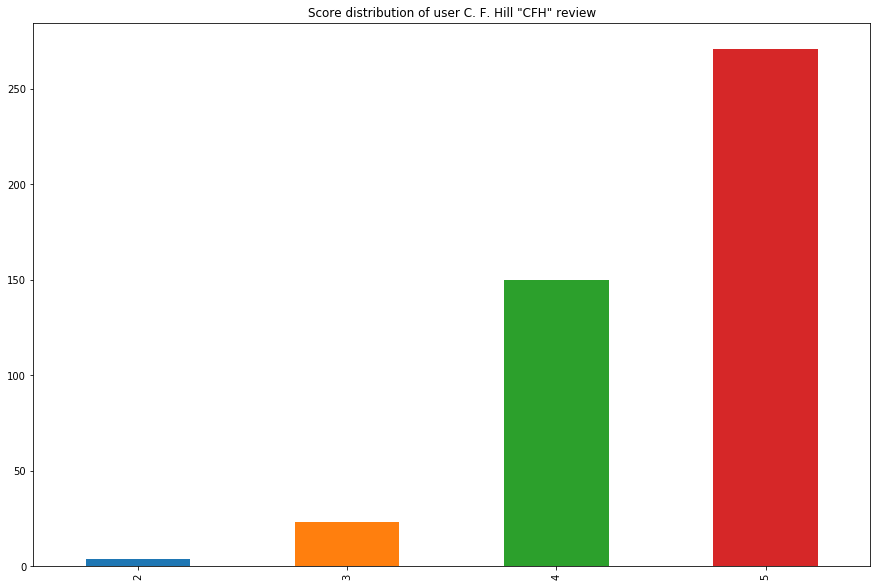

In [11]:
def plot_user(UserId):
    df_1user = odf[odf['UserId'] == UserId]['Score']
    df_1user_plot = df_1user.value_counts(sort=False)
    ax = df_1user_plot.plot(kind = 'bar', figsize = (15,10), title = 'Score distribution of user {} review'.format(odf[odf['UserId'] == UserId]['ProfileName'].iloc[0]))

plot_user('A3OXHLG6DIBRW8')


    我們可以發現該用戶的評分普遍偏高，但這並不能代表所有人都像他一樣什麼都不挑。
    因此我們可以設一個條件，取一個評分較合理，且有好有壞的用戶（condition : Score mean < 3.5）

In [12]:
print(df_user[(df_user['Score mean']<3.5) & (df_user['Score mean']>2.5)].head())

                                Score count  Score mean
UserId         ProfileName                             
A35R32TA60XD57 M. Torma                 141    3.460993
A2M9D9BDHONV3Y A. Bennett               115    3.269565
A2TN9C5E4A0I3F Jimmy                    110    2.727273
A2XNJJ9TF70P4J Angie                     85    2.976471
AJB5P7GVR0MT8  Harry the Horse           70    3.257143


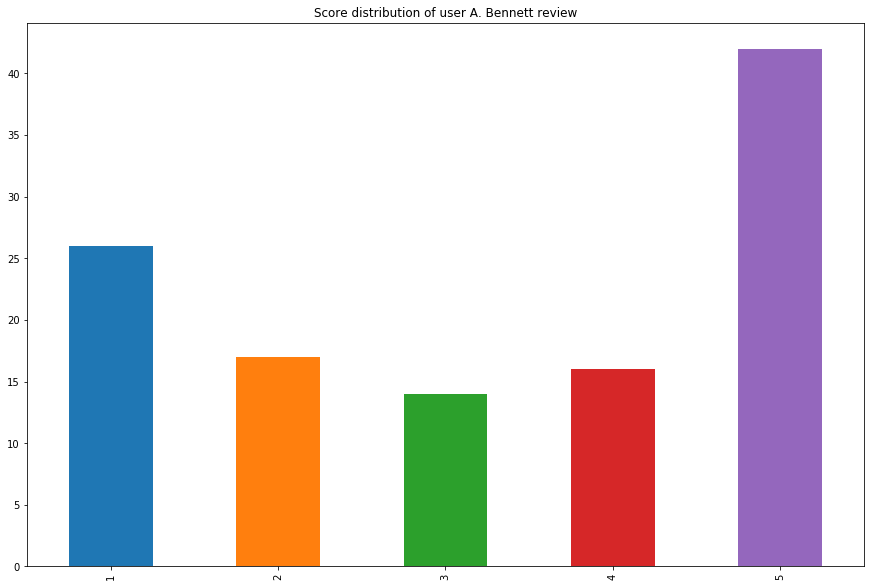

In [23]:
plot_user('A2M9D9BDHONV3Y')

    選定完符合我們條件的用戶後，將該用戶的評論取出，並藉由該評論分析，他在各不同評分中所用的字詞頻率與數量：

In [13]:
def get_token_ngram(score, benchmark, userid='all'):

    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'v') for w in total_text]
    bigrams = ngrams(total_text,2)
    trigrams = ngrams(total_text, 3)

    # look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
   Count  Occur %                   Phrase
0   31.0  119.23%               (..., ...)
1   17.0   65.38%          (..., ..., ...)
2   11.0   42.31%             (never, buy)
3    9.0   34.62%           (buy, product)
4    8.0   30.77%    (never, buy, product)
5    8.0   30.77%  (monosodium, glutamate)
6    7.0   26.92%            (decide, try)
7    7.0   26.92%         (dry, tasteless)
8    7.0   26.92%          (picture, look)
score 2 reviews most popular 2-gram / 3-gram:
    Count Occur %                Phrase
0     8.0  47.06%         (sauce, ruin)
1     8.0  47.06%         (ruin, whole)
2     8.0  47.06%  (sauce, ruin, whole)
3     6.0  35.29%            (n't, buy)
4     6.0  35.29%       (product, ever)
5     5.0  29.41%     (n't, get, wrong)
6     5.0  29.41%          (..., .give)
7     5.0  29.41%           (try, like)
8     5.0  29.41%          (.give, try)
9     5.0  29.41%    (.give, try, like)
10    5.0  29.41%     (buy, particular

    由以上結果，我們可以發現該用戶在2分的評論中喜歡用'give it a try'的片語，而5分的評論中喜歡用'highly recommend'這樣的片語。
    接著我們試著由分析該位用戶所得知結果推論到所有用戶：

In [14]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    # easier benchmark since we have many different users here, thus different phrase
    d = get_token_ngram(j, 0.03)
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  5536.0  10.59%   (taste, like)
1  2316.0   4.43%  (waste, money)
2  2175.0   4.16%    (could, n't)
3  2111.0   4.04%     (n't, even)
4  1809.0   3.46%     (n't, know)
5  1794.0   3.43%    (would, n't)
6  1644.0   3.15%      (n't, buy)
score 2 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  3161.0  10.62%   (taste, like)
1  1362.0   4.58%     (n't, like)
2  1304.0   4.38%    (would, n't)
3  1086.0   3.65%  (think, would)
4  1064.0   3.57%      (n't, buy)
5  1010.0   3.39%     (n't, know)
6   996.0   3.35%    (n't, taste)
7   945.0   3.17%    (could, n't)
8   910.0   3.06%   (taste, good)
score 3 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  3237.0   7.59%   (taste, like)
1  1632.0   3.83%    (would, n't)
2  1612.0   3.78%     (n't, like)
3  1551.0   3.64%   (taste, good)
4  1463.0   3.43%   (href=, http)
5  1406.0    3.3%     (n't, know)
6  1295.0   

    我們可以發現，不同用戶所喜歡使用的片語有很大的不同，這表示如果以片語來分析，並不是太好的作法，因為每個人的評論方式差異太大。
    因此，我們調整一下，改為利用單詞分析：

In [15]:
def get_token_adj(score, benchmark, userid='all'):
    
    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text]
    # get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']
    
    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

In [16]:
# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
   Count Occur %     Phrase
0   13.0   50.0%        dry
1   12.0  46.15%     cheese
2   10.0  38.46%        bad
3   10.0  38.46%     little
4    8.0  30.77%       hard
5    8.0  30.77%  delicious
6    8.0  30.77%      tasty
7    8.0  30.77%  expensive
8    7.0  26.92%       poor
9    7.0  26.92%      bread
score 2 reviews most popular adjectives word:
   Count Occur %      Phrase
0   10.0  58.82%       whole
1    8.0  47.06%      cheese
2    6.0  35.29%       wrong
3    6.0  35.29%   delicious
4    6.0  35.29%       awful
5    5.0  29.41%  particular
6    5.0  29.41%        good
7    5.0  29.41%       .give
score 3 reviews most popular adjectives word:
   Count Occur %        Phrase
0    9.0  64.29%         whole
1    5.0  35.71%          high
2    4.0  28.57%         first
3    4.0  28.57%          good
4    4.0  28.57%  disappointed
5    4.0  28.57%         great
score 4 reviews most popular adjectives word:
   Count Occur %     Phrase
0 

In [17]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.05)
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
      Count Occur %        Phrase
0   16185.0  30.97%          good
1   10777.0  20.62%           bad
2    4977.0   9.52%         great
3    4844.0   9.27%          much
4    4786.0   9.16%        little
5    4774.0   9.13%           old
6    4198.0   8.03%         first
7    3956.0   7.57%           new
8    3789.0   7.25%     different
9    3717.0   7.11%          many
10   3537.0   6.77%         small
11   3296.0   6.31%          real
12   3000.0   5.74%  disappointed
13   2884.0   5.52%          sure
14   2831.0   5.42%          free
15   2823.0    5.4%          diet
16   2761.0   5.28%          high
17   2658.0   5.09%          last
score 2 reviews most popular adjectives word:
      Count Occur %        Phrase
0   13519.0  45.41%          good
1    4251.0  14.28%          much
2    4169.0   14.0%           bad
3    3909.0  13.13%         great
4    3691.0   12.4%        little
5    2847.0   9.56%         small
6    2323.0    7.8%     

    我們可以看出相對於片語來說，字詞對我們的評論就比較有用了，例如從個人用戶評論分析中，我們可以清楚地得知該用戶討厭乾硬的食物、討厭起司等等 ; 而從所有評論中，我們可以淘汰掉一些在任何分數的評論中都常出現的字（代表該字對於我們好評與差評率的預測幾乎沒有幫助），便能得出較有影響力的單詞，便可以做出更精準的預測。
    
    在這次的作業中，我花了許多時間學習和複習一些之前學習過的知識（因為之前有自學過machine learning的課程），才發現有許多知識是沒有學習好的，另外，也因為之前所使用的資料都是課程裡面整理好的，甚至老師還會教怎麼處理這些資料，而這次的作業則是下載完資料檔後，一切重頭做起，包括我要利用這些資料預測什麼、如何分析與觀察這些資料、當結果與預期不同時又要如何調整等等，這些都是在做這次作業時，我學到的東西。
    
# 以上是HW4-6，謝謝老師、助教的評分、修改以及評論，謝謝！